# 0. Bibliotheken installieren

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import sqlite3
import os

# 1. Daten aus CSV-File in SQL-Datenbank speichern

In [32]:
# Pfad zur CSV-Datei
csv_file_path = 'Daten.csv'

# Lese die CSV-Datei mit Semikolon als Trennzeichen
data = pd.read_csv(csv_file_path, sep=';')

# Ausgabe von Informationen über die Daten
print("Allgemeine Informationen zur CSV-Datei:")
print(f"Anzahl der Zeilen: {len(data)}")
print(f"Anzahl der Spalten: {data.shape[1]}")
print(f"Spaltentitel: {list(data.columns)}")
print("\nDatentypen der Spalten:")
print(data.dtypes)

# Verbindung zur SQLite-Datenbank herstellen (oder erstellen, falls nicht vorhanden)
conn = sqlite3.connect('datenbank.db')

# Daten in die Datenbank schreiben (Tabelle wird automatisch erstellt)
data.to_sql('daten', conn, if_exists='replace', index=False)

print("\nDaten wurden erfolgreich in die SQLite-Datenbank importiert.")

# Verbindung schließen
conn.close()

Allgemeine Informationen zur CSV-Datei:
Anzahl der Zeilen: 1000000
Anzahl der Spalten: 6
Spaltentitel: ['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

Datentypen der Spalten:
TimeStamp      object
ActualPos      object
ActualForce     int64
Nahtnummer     object
LaserPwr        int64
Befehl         object
dtype: object

Daten wurden erfolgreich in die SQLite-Datenbank importiert.


# 2. Daten aufbereiten

In [33]:
# Verbindung zur bestehenden SQLite-Datenbank herstellen
conn_source = sqlite3.connect('datenbank.db')

# Daten aus der Datenbank lesen
print("Lese Daten aus der Datenbank...")
df = pd.read_sql_query("SELECT * FROM daten", conn_source)

# Schließe Quellverbindung
conn_source.close()

print(f"Anzahl der Zeilen vor der Bereinigung: {len(df)}")

# Datenbereinigung
print("\nBereinige Daten...")

# 1. Entferne Duplikate und erstelle explizit eine Kopie
df_cleaned = df.drop_duplicates().copy()
print(f"Nach Entfernen von Duplikaten: {len(df_cleaned)} Zeilen")

# 2. Behandle fehlende Werte und konvertiere Datentypen
# Konvertiere Timestamp zu datetime
if 'timestamp' in df_cleaned.columns:
    df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'], errors='coerce')
    # Ersetze fehlerhafte Zeitstempel mit dem Median-Zeitstempel
    if df_cleaned['timestamp'].isna().any():
        median_timestamp = df_cleaned['timestamp'].median()
        df_cleaned.loc[:, 'timestamp'] = df_cleaned['timestamp'].fillna(median_timestamp)
    print("Zeitstempel wurden konvertiert")

# Konvertiere Float-Werte
if 'actualpos' in df_cleaned.columns:
    df_cleaned.loc[:, 'actualpos'] = pd.to_numeric(df_cleaned['actualpos'], errors='coerce').fillna(
        df_cleaned['actualpos'].median())
    print("actualpos zu Float konvertiert")

# Konvertiere Integer-Werte
int_columns = ['actualforce', 'laserpw']
for col in int_columns:
    if col in df_cleaned.columns:
        df_cleaned.loc[:, col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(
            df_cleaned[col].median()).astype(int)
        print(f"{col} zu Integer konvertiert")

# Behandle Text-Spalten
text_columns = ['nahtnummer', 'befehl']
for col in text_columns:
    if col in df_cleaned.columns:
        df_cleaned.loc[:, col] = df_cleaned[col].fillna('').astype(str).str.strip()
        print(f"{col} als Text bereinigt")

# 3. Entferne Ausreißer für numerische Spalten (actualpos, actualforce, laserpw)
numeric_cols = ['actualpos', 'actualforce', 'laserpw']
for col in numeric_cols:
    if col in df_cleaned.columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

print(f"Nach Entfernen von Ausreißern: {len(df_cleaned)} Zeilen")

# 4. Formatiere Spaltennamen (kleinbuchstaben, keine Leerzeichen)
df_cleaned.columns = [col.lower().replace(' ', '_') for col in df_cleaned.columns]

print("\nBereinigung abgeschlossen.")
print(f"Anzahl der Zeilen nach der Bereinigung: {len(df_cleaned)}")

# Spezifiziere Datentypen für SQLite (optional: für bessere Typkonsistenz)
dtypes = {
    'timestamp': 'TIMESTAMP',
    'actualpos': 'REAL',
    'actualforce': 'INTEGER',
    'nahtnummer': 'TEXT',
    'laserpw': 'INTEGER',
    'befehl': 'TEXT'
}

# Verbindung zur neuen SQLite-Datenbank herstellen
conn_target = sqlite3.connect('datenbank_bereinigt.db')

# Bereinigte Daten in die neue Datenbank schreiben
df_cleaned.to_sql('daten_bereinigt', conn_target, if_exists='replace', index=False, 
                  dtype={k: v for k, v in dtypes.items() if k in df_cleaned.columns})

print("\nBereinigte Daten wurden erfolgreich in die neue SQLite-Datenbank 'datenbank_bereinigt.db' importiert.")
print("Tabelle: 'daten_bereinigt'")

# Verbindung schließen
conn_target.close()

Lese Daten aus der Datenbank...
Anzahl der Zeilen vor der Bereinigung: 1000000

Bereinige Daten...
Nach Entfernen von Duplikaten: 995472 Zeilen
Nach Entfernen von Ausreißern: 995472 Zeilen

Bereinigung abgeschlossen.
Anzahl der Zeilen nach der Bereinigung: 995472

Bereinigte Daten wurden erfolgreich in die neue SQLite-Datenbank 'datenbank_bereinigt.db' importiert.
Tabelle: 'daten_bereinigt'


# 3. Modellierung

Tables in the database: [('daten_bereinigt',)]
Loading data from table: daten_bereinigt
Converting 'actualpos' to numeric type (replacing commas with periods)

                                 DATA OVERVIEW                                  
Data preview:


,timestamp,actualpos,actualforce,nahtnummer,laserpwr,befehl
0,2021-06-21T14:27:15.007Z,1.10,-691,FIOF,380,PUTG348_46362103
1,2021-06-21T14:27:18.676Z,0.90,-691,FINK,381,PNB398
2,2021-06-21T14:27:52.196Z,-0.90,-691,KFG,398,PUTG348_46360609
3,2021-06-21T14:27:58.514Z,-21.30,155,EMMC,0,PNB117
4,2021-06-21T14:28:05.684Z,-68.50,79,FIOK,402,PNB195


Data shape: (995472, 6) (rows, columns)
Numeric columns: ['actualpos', 'actualforce', 'laserpwr']

                               SUMMARY STATISTICS                               


,actualpos,actualforce,laserpwr
count,995472.000000,995472.000000,995472.000000
mean,-8.200000,-575.160000,268.940000
std,136.100000,4025.100000,177.650000
min,-8192.000000,-151386.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-517.000000,396.000000
max,8191.900000,151388.000000,408.000000



                         DISTRIBUTIONS OF KEY VARIABLES                         


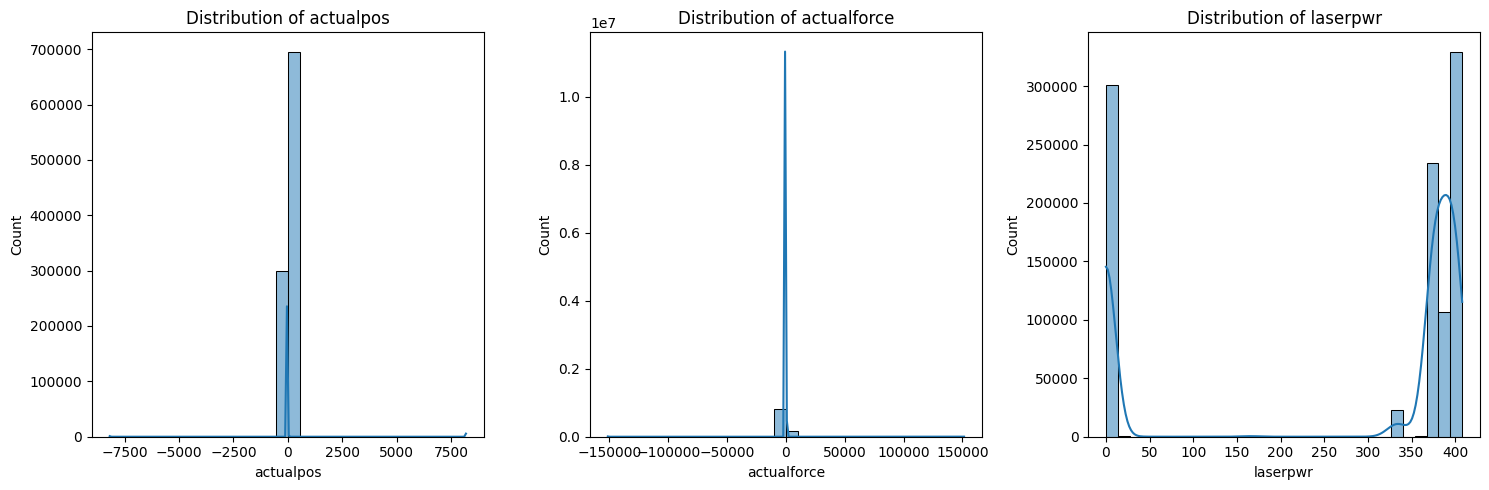


                              CORRELATION ANALYSIS                              


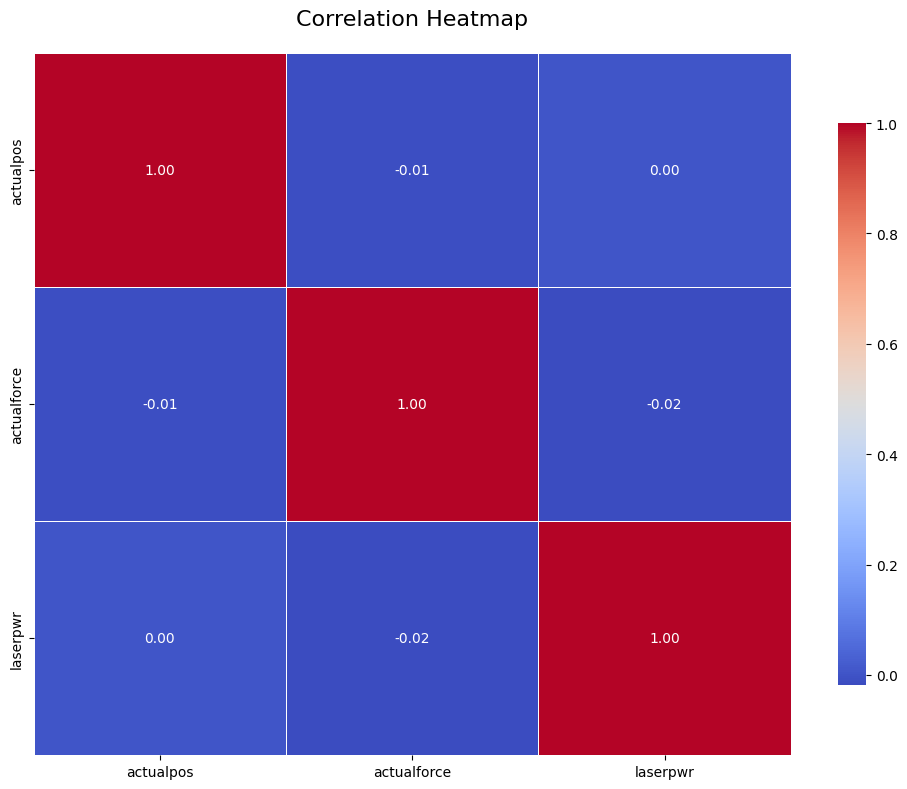


              RELATIONSHIP ANALYSIS: POSITION, FORCE & LASER POWER              


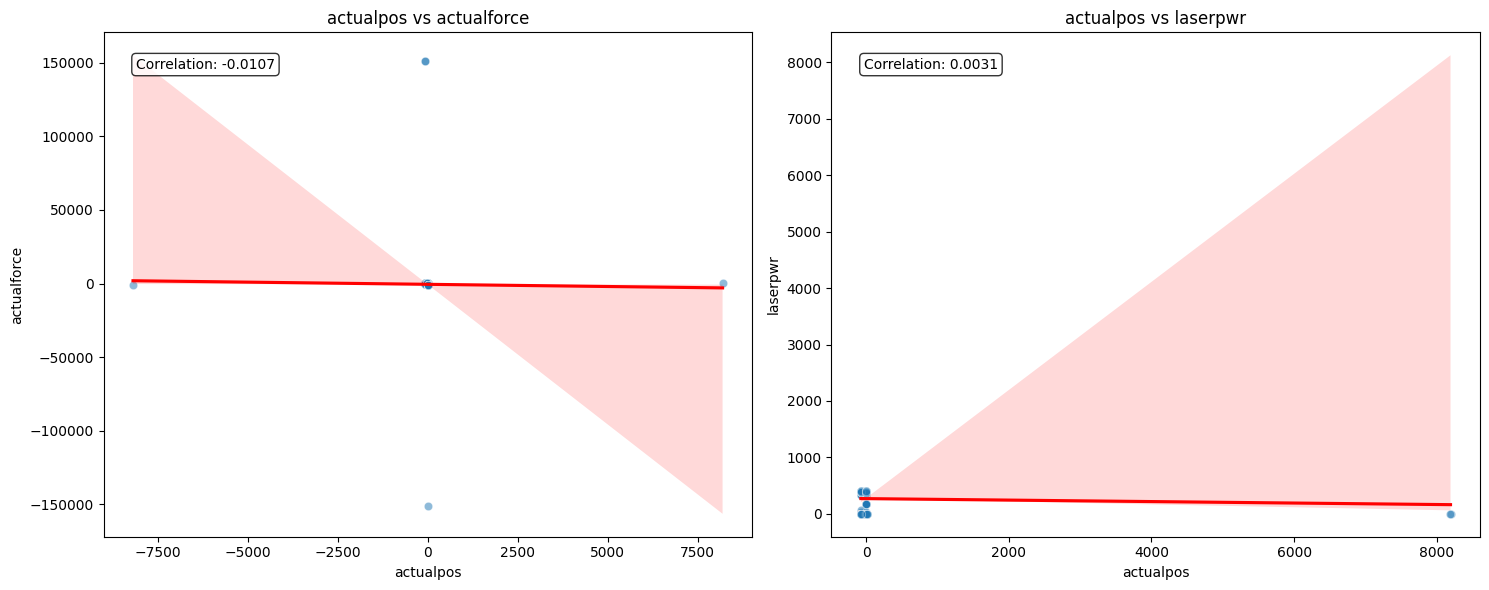

Correlation between actualpos and actualforce: -0.0107
Correlation between actualpos and laserpwr: 0.0031

                                OUTLIER ANALYSIS                                
Using timestamp for time series analysis
Successfully converted 995472 out of 995472 rows to valid dates


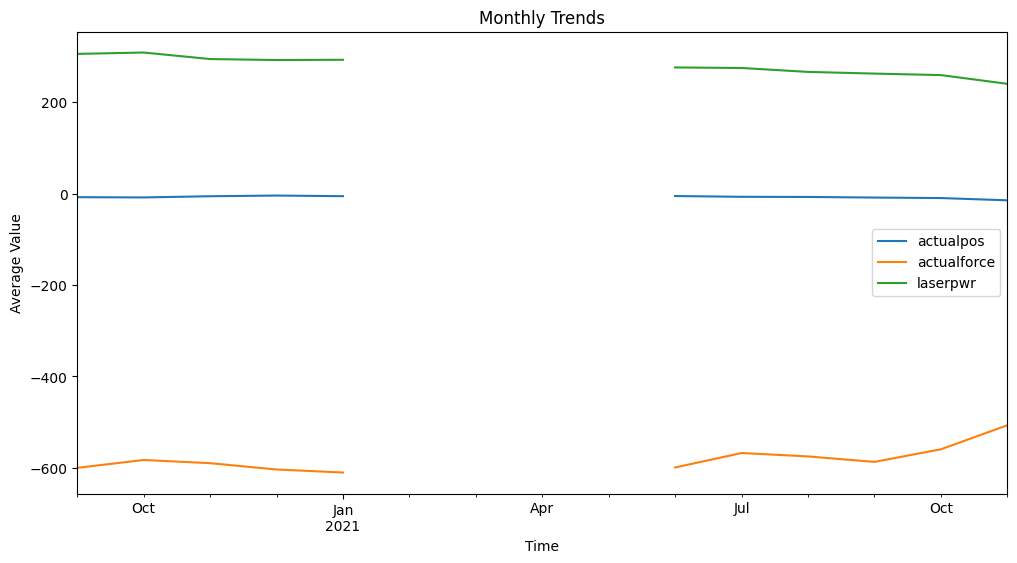

In [36]:
# Check if database file exists
db_path = 'datenbank_bereinigt.db'
if not os.path.exists(db_path):
    print(f"Error: Database file '{db_path}' not found.")
else:
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_path)
        
        # Get list of tables
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        print(f"Tables in the database: {tables}")
        
        if not tables:
            print("Error: No tables found in database.")
        else:
            try:
                # ...existing code...
                # Load the first table
                table_name = tables[0][0]
                print(f"Loading data from table: {table_name}")
                data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
                
                # Close the connection
                conn.close()
                
                if data.empty:
                    print("Error: No data retrieved from table.")
                else:
                    # Clean up actual pos column (replace commas with periods)
                    if 'actualpos' in data.columns:
                        print("Converting 'actualpos' to numeric type (replacing commas with periods)")
                        data['actualpos'] = data['actualpos'].astype(str).str.replace(',', '.').astype(float)
                    
                    # Display the first few rows of the dataset with improved formatting
                    print("\n" + "="*80)
                    print("DATA OVERVIEW".center(80))
                    print("="*80)
                    print("Data preview:")
                    display(data.head().style.format({"actualpos": "{:.2f}", 
                                                     "actualforce": "{:.0f}",
                                                     "laserpwr": "{:.0f}"}))
                    print(f"Data shape: {data.shape} (rows, columns)")
                    
                    # Identify numeric columns
                    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
                    print(f"Numeric columns: {numeric_columns}")
                    
                    if not numeric_columns:
                        print("Error: No numeric columns found for analysis.")
                    else:
                        # Summary statistics for numeric columns with better formatting
                        print("\n" + "="*80)
                        print("SUMMARY STATISTICS".center(80))
                        print("="*80)
                        display(data[numeric_columns].describe().round(2).style.background_gradient(cmap='Blues'))
                        
                        # Create a section for basic distributions
                        print("\n" + "="*80)
                        print("DISTRIBUTIONS OF KEY VARIABLES".center(80))
                        print("="*80)
                        
                        # Create a more organized layout with subplots for distributions
                        fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 5))
                        if len(numeric_columns) == 1:
                            axes = [axes]  # Handle single column case
                            
                        for i, column in enumerate(numeric_columns):
                            sns.histplot(data[column], kde=True, bins=30, ax=axes[i])
                            axes[i].set_title(f"Distribution of {column}")
                            axes[i].set_xlabel(column)
                            
                        plt.tight_layout()
                        plt.show()
                        
                        # Correlation analysis
                        print("\n" + "="*80)
                        print("CORRELATION ANALYSIS".center(80))
                        print("="*80)
                        
                        # Correlation heatmap for numeric features
                        plt.figure(figsize=(10, 8))
                        correlation_matrix = data[numeric_columns].corr()
                        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
                                   linewidths=0.5, cbar_kws={"shrink": .8})
                        plt.title("Correlation Heatmap", fontsize=16, pad=20)
                        plt.tight_layout()
                        plt.show()
                        
                        # Specific comparison between actualpos, actualforce, and laserpwr
                        print("\n" + "="*80)
                        print("RELATIONSHIP ANALYSIS: POSITION, FORCE & LASER POWER".center(80))
                        print("="*80)
                        
                        target_columns = ['actualpos', 'actualforce', 'laserpwr']
                        available_columns = [col for col in target_columns if col in data.columns]
                        
                        if len(available_columns) >= 2 and 'actualpos' in available_columns:
                            # Create a figure with multiple subplots for the relationships
                            other_cols = [c for c in available_columns if c != 'actualpos']
                            fig, axes = plt.subplots(1, len(other_cols), figsize=(15, 6))
                            if len(other_cols) == 1:
                                axes = [axes]  # Handle single column case
                                
                            for i, col in enumerate(other_cols):
                                # Sample data to avoid overcrowding the plot
                                sample_size = min(5000, len(data))
                                sample_data = data.sample(sample_size)
                                
                                # Create scatter plot with regression line
                                sns.scatterplot(x='actualpos', y=col, data=sample_data, alpha=0.5, ax=axes[i])
                                sns.regplot(x='actualpos', y=col, data=sample_data, scatter=False, 
                                           line_kws={"color":"red"}, ax=axes[i])
                                
                                axes[i].set_title(f"actualpos vs {col}")
                                
                                # Calculate and display correlation on plot
                                correlation = data[['actualpos', col]].corr().iloc[0, 1]
                                axes[i].annotate(f"Correlation: {correlation:.4f}", 
                                               xy=(0.05, 0.95), xycoords='axes fraction',
                                               ha='left', va='top',
                                               bbox=dict(boxstyle='round', fc='white', alpha=0.8))
                            
                            plt.tight_layout()
                            plt.show()
                            
                            # Print correlation metrics
                            for col in other_cols:
                                correlation = data[['actualpos', col]].corr().iloc[0, 1]
                                print(f"Correlation between actualpos and {col}: {correlation:.4f}")
                        else:
                            print("Cannot compare actualpos with actualforce and laserpwr: some columns not found")
                            
                        # Add boxplots for outlier detection
                        print("\n" + "="*80)
                        print("OUTLIER ANALYSIS".center(80))
                        print("="*80)
                        
                        # Trend analysis for time-series data (if applicable)
                        timestamp_cols = [col for col in data.columns if 'time' in col.lower() or 'date' in col.lower()]
                        if timestamp_cols:
                            timestamp_col = timestamp_cols[0]
                            print(f"Using {timestamp_col} for time series analysis")
                            
                            # Create a copy to avoid modifying original data
                            time_data = data.copy()
                            time_data[timestamp_col] = pd.to_datetime(time_data[timestamp_col], errors='coerce')
                            
                            # Check for successful date conversion
                            valid_dates = time_data[timestamp_col].notna().sum()
                            print(f"Successfully converted {valid_dates} out of {len(time_data)} rows to valid dates")
                            
                            # Drop rows with invalid dates
                            time_data = time_data.dropna(subset=[timestamp_col])
                            
                            if time_data.empty:
                                print("Error: No valid date entries found for time series analysis.")
                            else:
                                time_data.set_index(timestamp_col, inplace=True)
                                
                                try:
                                    # Monthly average trends
                                    plt.figure(figsize=(12, 6))
                                    for column in numeric_columns:
                                        time_data[column].resample("ME").mean().plot(label=column)
                                    
                                    plt.title("Monthly Trends")
                                    plt.xlabel("Time")
                                    plt.ylabel("Average Value")
                                    plt.legend()
                                    plt.show()
                                except Exception as e:
                                    print(f"Error in time series analysis: {str(e)}")
            except Exception as e:
                print(f"Error processing data: {str(e)}")
    except sqlite3.Error as e:
        print(f"Database error: {str(e)}")